In [2]:
## Make width of notebook 90%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from datasets import data as Local ## Local module to get dataframes

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [35]:
games_df, winners_df, cumulative_stats_df, games_details_df, teams_df, players_df, ranking_df = Local.get_all_dataset_dataframes('../../datasets/')

In [36]:
winners_df # Whether the home team won in a game in each row of `games_df`

16157    1
16156    1
16155    1
16154    1
16153    1
        ..
4        0
3        0
2        0
1        1
0        1
Name: HOME_TEAM_WINS, Length: 23520, dtype: int64

In [37]:
winners_df.describe()

count    23520.000000
mean         0.591029
std          0.491654
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_TEAM_WINS, dtype: float64

Home team has winrate of 59.1%

# Remove non-data

In [38]:
cumulative_stats_copy_df = cumulative_stats_df.copy()

# Remove rows where games_played==0
cumulative_stats_copy_df = cumulative_stats_copy_df.loc[(cumulative_stats_copy_df['GAMES_PLAYED_home']>0) & (cumulative_stats_copy_df['GAMES_PLAYED_away']>0)]

for key in ['DATE','GAME_ID','TEAM_ID_home','TEAM_ID_away','SEASON_TYPE','SEASON','GAMES_PLAYED_home','GAMES_PLAYED_away']:
    del cumulative_stats_copy_df[key]
# Only look at home teams
# cumulative_stats_copy_df = cumulative_stats_copy_df.loc[cumulative_stats_copy_df['AT_HOME']==True]
# del cumulative_stats_copy_df['AT_HOME']

# Add hometeam win/loss column
cumulative_stats_copy_df['HOME_WIN'] = winners_df

cumulative_stats_copy_df

,APG_total_home,FG_PCT_total_home,FG3_PCT_total_home,FT_PCT_total_home,PPG_total_home,RPG_total_home,APG_total_away,FG_PCT_total_away,FG3_PCT_total_away,FT_PCT_total_away,PPG_total_away,RPG_total_away,W_PCT_away,W_PCT_home,HOME_WIN
0,23.000000,0.457000,0.143000,0.735000,90.000000,41.000000,20.0,0.44700,0.25000,0.50000,85.00,38.00,0.00,0.000,1
1,25.000000,0.494000,0.267000,0.618000,105.000000,48.000000,20.0,0.42700,0.15400,0.70000,94.00,43.00,0.00,0.000,1
2,19.000000,0.467000,0.444000,0.871000,101.000000,39.000000,13.0,0.36800,0.36400,0.60900,82.00,50.00,0.00,0.000,0
3,22.000000,0.527000,0.429000,0.657000,104.000000,33.000000,10.0,0.47000,0.33300,0.66700,80.00,37.00,0.00,0.000,0
4,15.000000,0.352000,0.222000,0.647000,86.000000,55.000000,7.0,0.32900,0.14300,0.89700,79.00,44.00,0.00,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23515,25.666667,0.422333,0.354000,0.706333,109.333333,40.000000,28.0,0.48050,0.39850,0.77950,104.50,43.00,0.50,0.667,1
23516,23.666667,0.415667,0.342667,0.643333,105.666667,38.666667,23.0,0.50200,0.29800,0.68950,110.50,45.00,1.00,0.000,0
23517,28.250000,0.450000,0.346000,0.714500,118.500000,50.250000,24.0,0.40000,0.32350,0.80150,112.75,53.75,0.50,0.750,1
23518,22.666667,0.419000,0.312667,0.678000,99.666667,44.666667,19.5,0.41050,0.33125,0.69650,94.00,44.00,0.50,0.333,1


In [24]:
standardized_stats_data_df = pd.DataFrame(StandardScaler().fit_transform(cumulative_stats_copy_df), columns=cumulative_stats_copy_df.columns)

# Covariance Matrix

In [25]:
standardized_stats_data_df.cov().style.background_gradient(cmap='rainbow',axis=None)

,APG_total_home,FG_PCT_total_home,FG3_PCT_total_home,FT_PCT_total_home,PPG_total_home,RPG_total_home,APG_total_away,FG_PCT_total_away,FG3_PCT_total_away,FT_PCT_total_away,PPG_total_away,RPG_total_away,W_PCT_away,W_PCT_home,HOME_WIN
APG_total_home,1.000043,0.537919,0.293432,0.138272,0.634251,0.266608,0.216462,0.078569,0.040476,0.118751,0.323561,0.205271,-0.002452,0.304793,0.000890
FG_PCT_total_home,0.537919,1.000043,0.457276,0.154988,0.576816,-0.032269,0.085103,0.128211,0.062975,0.111112,0.174848,-0.055543,-0.043989,0.468351,0.013624
FG3_PCT_total_home,0.293432,0.457276,1.000043,0.172064,0.319186,-0.045483,0.045963,0.046357,0.033695,0.053202,0.068040,-0.009144,-0.043015,0.336156,0.009432
FT_PCT_total_home,0.138272,0.154988,0.172064,1.000043,0.266307,-0.009299,0.124159,0.119325,0.069952,0.096857,0.164678,0.059890,0.022299,0.123621,-0.011614
PPG_total_home,0.634251,0.576816,0.319186,0.266307,1.000043,0.456939,0.329352,0.178420,0.084238,0.166970,0.547752,0.290867,-0.004285,0.323741,0.008040
RPG_total_home,0.266608,-0.032269,-0.045483,-0.009299,0.456939,1.000043,0.211445,-0.050247,-0.024459,0.059563,0.293495,0.281159,-0.017810,0.195306,-0.006865
APG_total_away,0.216462,0.085103,0.045963,0.124159,0.329352,0.211445,1.000043,0.544596,0.294821,0.153141,0.642011,0.272146,0.323276,-0.020996,-0.005039
FG_PCT_total_away,0.078569,0.128211,0.046357,0.119325,0.178420,-0.050247,0.544596,1.000043,0.478924,0.153292,0.583566,-0.028381,0.502278,-0.067210,0.007552
FG3_PCT_total_away,0.040476,0.062975,0.033695,0.069952,0.084238,-0.024459,0.294821,0.478924,1.000043,0.160648,0.325039,-0.047973,0.351334,-0.055689,0.012187
FT_PCT_total_away,0.118751,0.111112,0.053202,0.096857,0.166970,0.059563,0.153141,0.153292,0.160648,1.000043,0.268589,-0.010577,0.143804,-0.005988,-0.005032


# Scatter Matrix

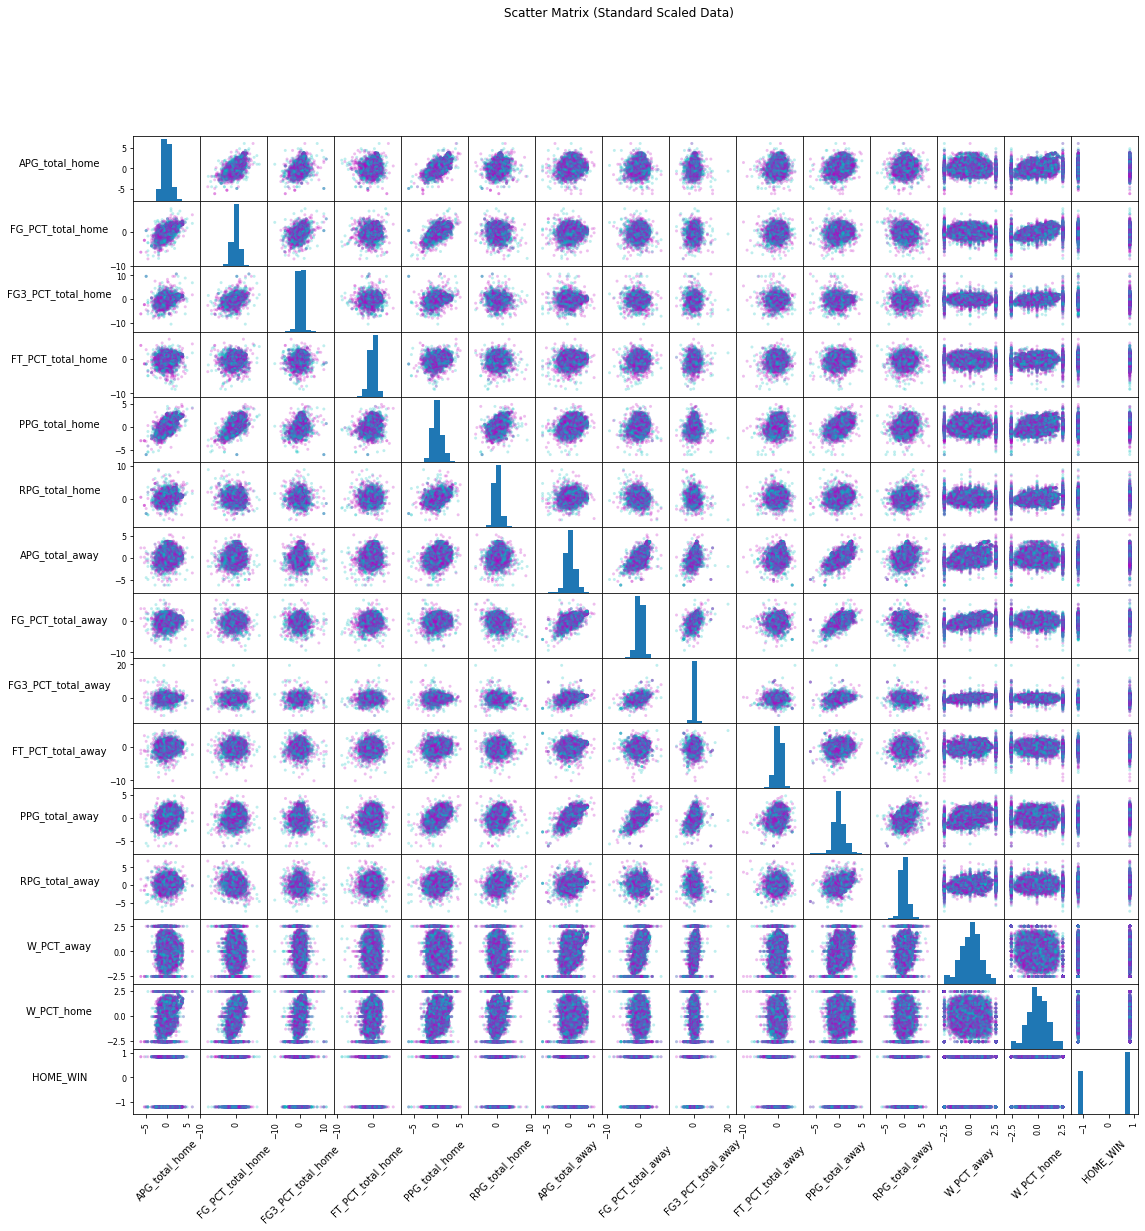

In [27]:
sm=pd.plotting.scatter_matrix(
    standardized_stats_data_df,
    alpha=0.25,
    figsize=(18,18),
    diagonal='hist',
    range_padding=0.3, # More padding to fit labels
    c=['c','m']*(len(standardized_stats_data_df)//2)+['c'], # Color differentiate points from different data
)
# Rotate & reposition labels
# (referenced https://stackoverflow.com/questions/32560932/how-to-customize-a-scatter-matrix-to-see-all-titles)
for s in sm.reshape(-1):
    s.xaxis.label.set_rotation(45)
    s.yaxis.label.set_rotation(0)
    s.get_yaxis().set_label_coords(-1.1,0.5)
plt.suptitle('Scatter Matrix (Standard Scaled Data)')
plt.show()

# Train test split 80/20

In [39]:
cumulative_stats_data_df = cumulative_stats_df.copy()

for key in ['DATE','GAME_ID','TEAM_ID_home','TEAM_ID_away','SEASON_TYPE','SEASON','GAMES_PLAYED_home','GAMES_PLAYED_away']:
    del cumulative_stats_data_df[key]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    cumulative_stats_data_df,
    winners_df,
    train_size=0.8,
    random_state=0,
)

# Train KMeans

In [ ]:
kmeans_model = KMeans(n_clusters=2, random_state=0).fit(X_train)

In [72]:
kmeans_model.score(X_test, y_test)

-412733.7981879218

In [86]:
correct_df = pd.Series([x==y for x,y in zip(kmeans_model.predict(X_test), y_test)])
len(correct_df.loc[correct_df==True])/len(correct_df)

0.4766156462585034

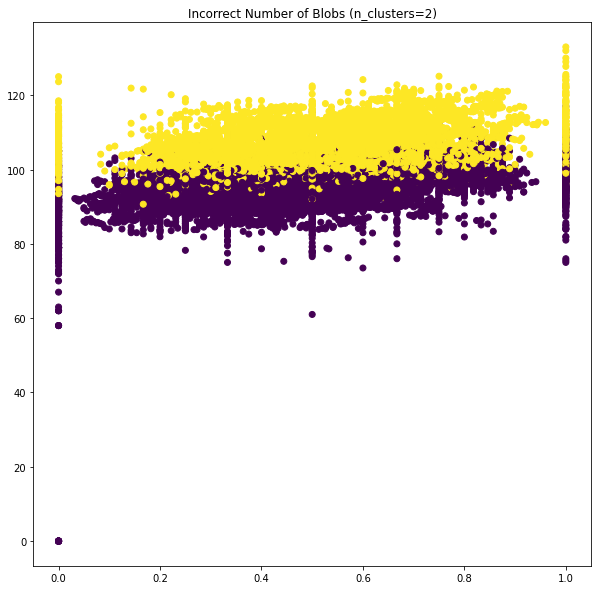

In [84]:
plt.figure(figsize=(10, 10))
plt.scatter(cumulative_stats_data_df['W_PCT_away'], cumulative_stats_data_df['PPG_total_away'], c=kmeans_model.predict(cumulative_stats_data_df))
plt.title(f"Incorrect Number of Blobs (n_clusters={2})")

plt.show()

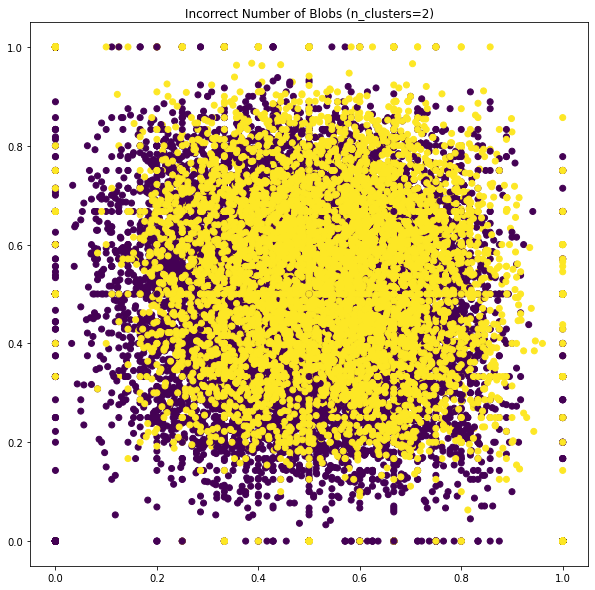

In [83]:
plt.figure(figsize=(10, 10))
plt.scatter(cumulative_stats_data_df['W_PCT_away'], cumulative_stats_data_df['W_PCT_home'], c=kmeans_model.predict(cumulative_stats_data_df))
plt.title(f"Incorrect Number of Blobs (n_clusters={2})")

plt.show()

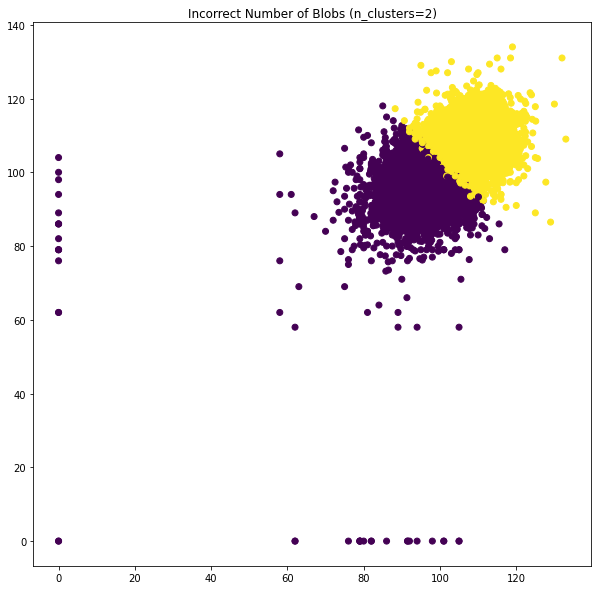

In [68]:
plt.figure(figsize=(10, 10))
plt.scatter(cumulative_stats_data_df['PPG_total_away'], cumulative_stats_data_df['PPG_total_home'], c=kmeans_model.predict(cumulative_stats_data_df))
plt.title(f"Incorrect Number of Blobs (n_clusters={2})")

plt.show()